In [9]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]
mpl.rcParams['text.usetex'] = True

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, plotting, modeleval

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

In [2]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn import model_selection

# The data

`x` indicates activity, partitioned into eight quarters, for the four channels ABCD.
`y` indicates movement.

In [6]:
data_path = '../../allan_data/DataPredictMovement_half.p'

In [7]:
x, y = np.load(data_path) 

Plotting the average value of the `x`-vectors, we see that every first quarter of an lower amound of activity. This could reflect human behaviour, because events often start on an hourly basis, or it could be a binning problem.

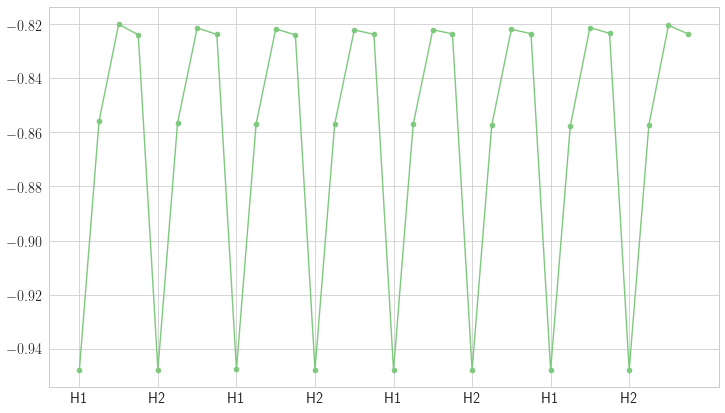

In [11]:
fig, ax = plt.subplots()
ax.plot(x.mean(axis=0), 'o-', c=colorcycle[0])
# xticks = np.array([np.array([0, 3]) + (i*4) for i in range(0, 8)]).ravel()
xticks = np.arange(0, 32, 4)
ax.set_xticks(xticks)
ax.set_xticklabels(["H1", "H2"]*4);
fig.savefig('quarters_vvalue.pdf')

Below is the average of the four quarters in an hour. The same effect with low counts in the first quarter is seen.

In [12]:
means = np.zeros(4)
base_idx = np.arange(0, 32, 4)
for i in range(4):
    idx = base_idx + i
    icut = min(base_idx[-1]+i, x.shape[1])
    idx = idx[idx <= icut]
    arr = x[:, base_idx + i]
    means[i] = arr.mean()
    print("%.3f" % means[i])


-0.948
-0.857
-0.821
-0.824


In [13]:
np.savetxt('quarterly_averages_accross_all_channels.txt', means)

Heatmap of the correlation shows the same pattern... perhaps a dimmensionality reduction is in order, since the intrinsic dimmension of the data might be quite a bit smaller than the current dimmensionalty.

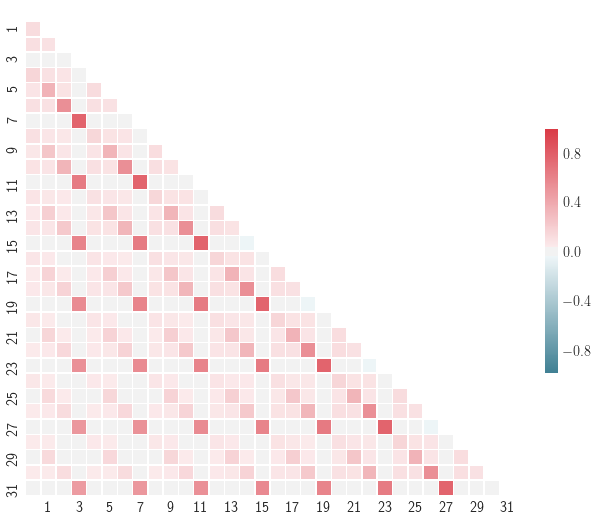

In [50]:
sample_idx = np.random.choice(range(len(y)), len(y)//25) 
dfs = pd.DataFrame(x[sample_idx, :])
corr = dfs.corr() 

with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    # ticks = [str(i) if (i % 2 == 1) else ' ' for i in range(32)]
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}) 
    for lx, ly in zip(ax.get_xticklabels()[::2], ax.get_yticklabels()[::2]):
        lx.set_visible(False)
        ly.set_visible(False) 
    
    fig.savefig("quarters_correlations.pdf") 

In [51]:
pca = PCA() 
pca.fit(x)
xx = pca.transform(x)

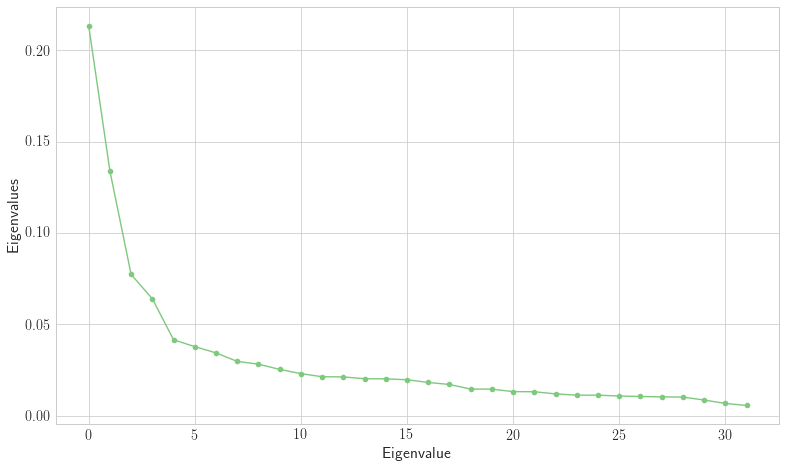

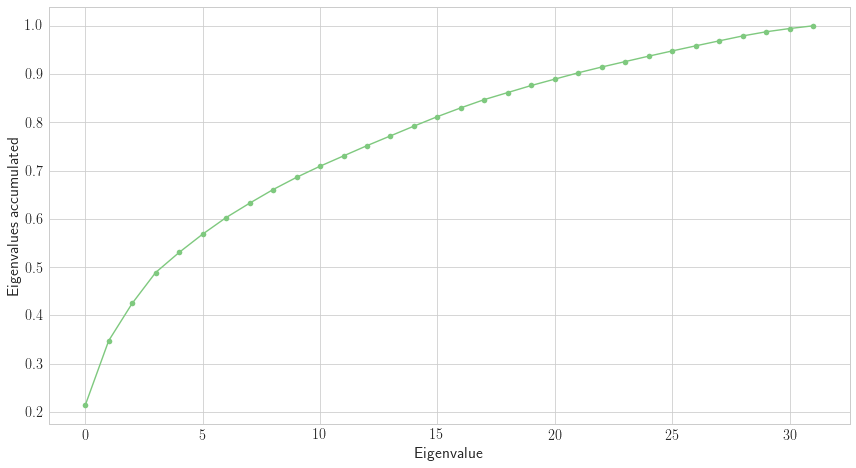

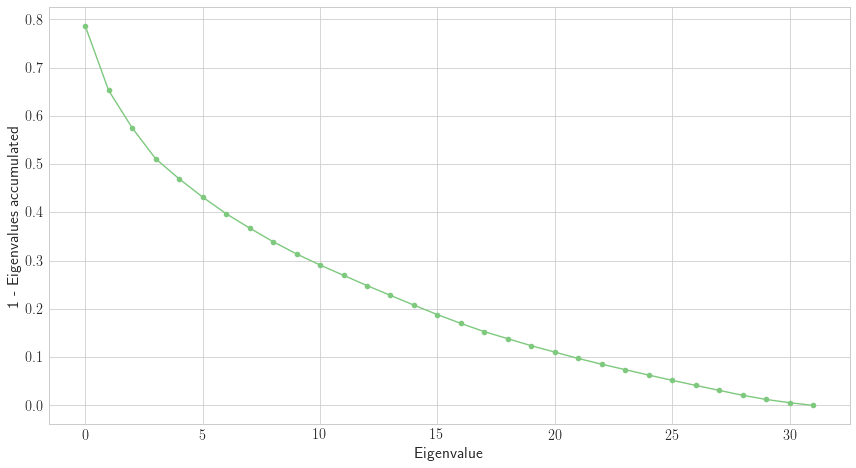

In [56]:
fig, ax = plt.subplots() 
ax.set_ybound(-0.05, 0.25)
ax.plot(pca.explained_variance_ratio_, 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues')
plt.tight_layout() 
fig.subplots_adjust(left=0.15, bottom=0.15)
fig.savefig('pca_eigenvalues.pdf')

fig, ax = plt.subplots()
ax.set_ybound(-0.05, 1.05)
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues accumulated')
plt.tight_layout() 
fig.subplots_adjust(bottom=0.15)
fig.savefig('pca_eigenvalues_accumulated.pdf')

fig, ax = plt.subplots()
ax.set_ybound(-0.05, 1.05)
ax.plot(1 - np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('1 - Eigenvalues accumulated')
plt.tight_layout() 
fig.subplots_adjust(bottom=0.15)
fig.savefig('pca_eigenvalues_scree.pdf')